# The ROC evaluation of QC experiments 

In [1]:
import sys
from glob import glob
from datetime import datetime, timedelta

import h5py
import numpy as np
import pandas as pd

from scipy import interp
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
save_dir = '/glade/work/ksha/data/Keras/QC_publish/'
eval_dir = '/glade/work/ksha/data/evaluation/'

sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

%matplotlib inline

In [4]:
REDs = []
REDs.append(gu.xcolor('light salmon'))
REDs.append(gu.xcolor('light coral'))
REDs.append(gu.xcolor('indian red'))
REDs.append(gu.xcolor('dark red'))

BLUEs = []
BLUEs.append(gu.xcolor('light blue'))
BLUEs.append(gu.xcolor('sky blue'))
BLUEs.append(gu.xcolor('royal blue'))
BLUEs.append(gu.xcolor('midnight blue'))

JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))
JET = JET[::-1]

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# ROC and AUC bootstrapping

In [7]:
# bootstrapped ROC curve

def ROC_range(FP_boost, TP_boost, N):
    FP_base = np.linspace(0, 1, N)
    TP_base = np.empty((TP_boost.shape[0], N))
    for i in range(TP_boost.shape[0]):
        TP_base[i, :] = interp(FP_base, FP_boost[i, :], TP_boost[i, :])
    TP_std = np.nanstd(TP_base, axis=0)
    TP_mean = np.nanmean(TP_base, axis=0)
    TP_upper = np.minimum(TP_mean + 3*TP_std, 1)
    TP_lower = np.maximum(TP_mean - 3*TP_std, 0)
    return FP_base, TP_mean, TP_lower, TP_upper

## AUC results (no bootstrap)

In [8]:
# # Importing results
data_temp = np.load(eval_dir+'EVAL_QC_members.npy', allow_pickle=True)
AUC_elev_eval = data_temp[()]['AUC']
# cate_train = data_temp[()]['cate_train']
# cate_valid = data_temp[()]['cate_valid']
# cate_test = data_temp[()]['cate_test']
# REPORT = data_temp[()]['REPORT']
# TP = data_temp[()]['TP']
# FP = data_temp[()]['FP']
# names = list(REPORT.keys())

data_temp = np.load(eval_dir+'EVAL_QC_noelev_members.npy', allow_pickle=True)
AUC_noelev_eval = data_temp[()]['AUC']

data_temp = np.load(eval_dir+'EVAL_QC_MLP_members.npy', allow_pickle=True)
AUC_mlp_eval = data_temp[()]['AUC']

## Bootstrap results

In [9]:
with h5py.File(BACKUP_dir+'HIGH_CAPA_TEST_pack.hdf', 'r') as h5io:
    cate_out = h5io['cate_out'][...]
    
with h5py.File(eval_dir+'EVAL_QC_MLP_boost.hdf', 'r') as h5io:
    cate_boost_mlp = h5io['cate_boost'][...]
    FP_mlp = h5io['FP_boost'][...]
    TP_mlp = h5io['TP_boost'][...]
    AUC_mlp = h5io['AUC_boost'][...]

with h5py.File(eval_dir+'EVAL_QC_noelev_boost.hdf', 'r') as h5io:
    FP_noelev = h5io['FP_boost'][...]
    TP_noelev = h5io['TP_boost'][...]
    AUC_noelev = h5io['AUC_boost'][...]

with h5py.File(eval_dir+'EVAL_QC_boost.hdf', 'r') as h5io:
    cate_p = h5io['cate_p'][...]
    cate_boost = h5io['cate_boost'][...]
    FP_elev = h5io['FP_boost'][...]
    TP_elev = h5io['TP_boost'][...]
    AUC_elev = h5io['AUC_boost'][...]
    
temp_data = np.load(eval_dir+'ENS_boost.npy', allow_pickle=True)
TP_ens = temp_data[()]['TP']
FP_ens = temp_data[()]['FP']
AUC_ens = temp_data[()]['AUC']

## Extra decision tree results

In [10]:
data_temp = np.load(eval_dir+'EVAL_QC_TREE_members.npy', allow_pickle=True)
cate_tree = data_temp[()]['cate_test']
auc_tree = data_temp[()]['AUC']

AUC_tree = np.empty(AUC_mlp.shape)
FP_tree = np.empty(FP_mlp.shape); FP_tree[...] = np.nan
TP_tree = np.empty(TP_mlp.shape); TP_tree[...] = np.nan

inds = np.arange(len(cate_out), dtype=np.int)

for i in range(5):
    for j in range(200):

        inds_ = resample(inds)
        fpr_, tpr_, _ = roc_curve(cate_out[inds_], cate_tree[inds_, i])
        AUC_tree[i, j] = auc(fpr_, tpr_)
        L = len(fpr_)
        FP_tree[i, j, :L] = fpr_
        TP_tree[i, j, :L] = tpr_

# Plot

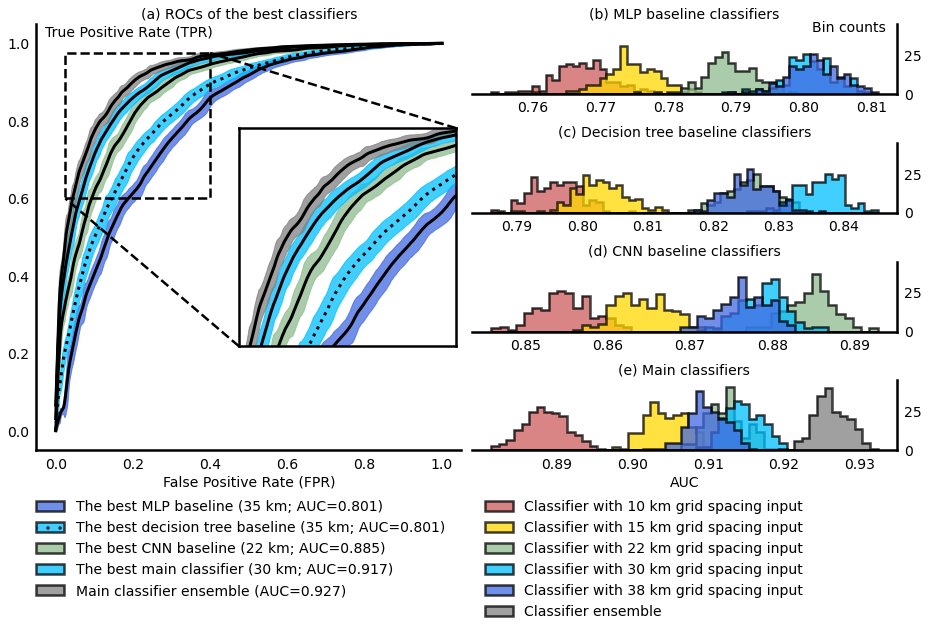

In [11]:
ens = 5
labels = ['10 km', '15 km', '22 km', '30 km', '38 km']

#BINS = np.linspace(np.min(AUC_mlp), np.max(AUC_elev), 100)
BINS1 = np.arange(np.min(AUC_mlp), np.max(AUC_mlp)+0.001, 0.001)
BINS2 = np.arange(np.min(AUC_tree), np.max(AUC_tree)+0.001, 0.001)
BINS3 = np.arange(np.min(AUC_noelev), np.max(AUC_noelev)+0.001, 0.001)
BINS4 = np.arange(np.min(AUC_elev), np.max(AUC_ens)+0.001, 0.001)

fig = plt.figure(figsize=(13, 7))
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

AX_hist = [ax2, ax3, ax4, ax5]

ax1 = gu.ax_decorate(ax1, True, True)
ax1.spines["bottom"].set_visible(True)
ax1.grid(False)

for ax in AX_hist:
    ax = gu.ax_decorate(ax, True, True)
    ax.grid(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)
    ax.tick_params(axis="both", which="both", 
                   bottom=False, top=False, labelbottom=True, 
                   left=False, labelleft=False, right=False, labelright=True)
    ax.set_ylim([0, 45])

ax2.text(0.975, 0.95, 'Bin counts', ha='right', va='center', transform=ax2.transAxes, fontsize=14)
ax3.yaxis.set_label_position("right")
ax5.set_xticks([0.89, 0.90, 0.91, 0.92, 0.93])
ax5.set_xlabel('AUC', fontsize=14)

ax1.set_xlabel('False Positive Rate (FPR)', fontsize=14)
ax1.text(0.02, 0.98, 'True Positive Rate (TPR)', ha='left', va='center', transform=ax1.transAxes, fontsize=14)
ax1_sub = zoomed_inset_axes(ax1, 1.5, loc=5)
ax1_sub = gu.ax_decorate(ax1_sub, False, False)
[j.set_linewidth(2.5) for j in ax1_sub.spines.values()]
ax1_sub.spines["left"].set_visible(True)
ax1_sub.spines["right"].set_visible(True)
ax1_sub.spines["bottom"].set_visible(True)
ax1_sub.spines["top"].set_visible(True)
ax1_sub.set_xlim([0.025, 0.4])
ax1_sub.set_ylim([0.6, 0.975])
ax1_sub.grid(False)

ind = 1
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_mlp[ind, ...], TP_mlp[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[0], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[0], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

ind = 1
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_tree[ind, ...], TP_tree[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, ls=':', color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, ls=':', color='k')

ind = 2
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_noelev[ind, ...], TP_noelev[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[2], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[2], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

ind = 0
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_elev[ind, ...], TP_elev[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_ens, TP_ens, 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color='0.5', alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color='0.5', alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

mark_inset(ax1, ax1_sub, loc1=1, loc2=3, fc='none', ec='k', lw=2.5, ls='--')
legend_patch = []; 
for i in range(ens):
    std_auc = []
    # MLP baseline
    ax2.hist(AUC_mlp[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS1)
    ax2.hist(AUC_mlp[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS1)
    std_auc.append(np.around(1e3*np.std(AUC_mlp[ens-1-i, :]), 2))
    # TREE baseline
    ax3.hist(AUC_tree[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS2)
    ax3.hist(AUC_tree[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS2)
    std_auc.append(np.around(1e3*np.std(AUC_tree[ens-1-i, :]), 2))
    
    # CNN baseline
    ax4.hist(AUC_noelev[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS3)
    ax4.hist(AUC_noelev[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS3)
    std_auc.append(np.around(1e3*np.std(AUC_noelev[ens-1-i, :]), 2))
    # CNN ours
    ax5.hist(AUC_elev[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS4)
    ax5.hist(AUC_elev[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS4)
#     std_auc.append(np.around(1e3*np.std(AUC_elev[ens-1-i, :]), 2))
#     legend_patch.append(mpatches.Patch(facecolor=JET[ens-1-i], edgecolor='k', linewidth=2.5, alpha=0.75, 
#                                        label='Classifier with {} input, std=({},{},{},{}) 1e-3'.format(
#                                            labels[i], std_auc[0], std_auc[1], std_auc[2], std_auc[3])))

    legend_patch.append(mpatches.Patch(facecolor=JET[ens-1-i], edgecolor='k', linewidth=2.5, alpha=0.75, 
                                       label='Classifier with {} grid spacing input'.format(labels[i])))
# (extra) classifier ensemble
ax5.hist(AUC_ens, alpha=0.75, histtype='stepfilled', facecolor='0.5', bins=BINS4)    
ax5.hist(AUC_ens, alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS4)
# std_ens = np.around(1e3*np.std(AUC_ens), 2)
# legend_patch.append(mpatches.Patch(facecolor='0.5', edgecolor='k', linewidth=2.5, alpha=0.75, 
#                                    label='Classifier ensemble, std = {} 1e-3'.format(std_ens)))

legend_patch.append(mpatches.Patch(facecolor='0.5', edgecolor='k', linewidth=2.5, alpha=0.75, 
                                   label='Classifier ensemble'))

legend_roc = [] 
legend_roc.append(
    mpatches.Patch(facecolor=JET[0], edgecolor='k', linewidth=2.5, alpha=0.75, 
                   label='The best MLP baseline (35 km; AUC={0:0.3f})'.format(AUC_mlp_eval['ENS0'])))
legend_roc.append(
    mpatches.Patch(facecolor=JET[1], hatch='.', edgecolor='k', linewidth=2.5, alpha=0.75, 
                   label='The best decision tree baseline (35 km; AUC={0:0.3f})'.format(AUC_mlp_eval['ENS0'])))
legend_roc.append(
    mpatches.Patch(facecolor=JET[2], edgecolor='k', linewidth=2.5, alpha=0.75,
                   label='The best CNN baseline (22 km; AUC={0:0.3f})'.format(AUC_noelev_eval['ENS2'])))
legend_roc.append(
    mpatches.Patch(facecolor=JET[1], edgecolor='k', linewidth=2.5, alpha=0.75, 
                   label='The best main classifier (30 km; AUC={0:0.3f})'.format(AUC_elev_eval['ENS1'])))
legend_roc.append(
    mpatches.Patch(facecolor='0.5', edgecolor='k', linewidth=2.5, alpha=0.75,
                   label='Main classifier ensemble (AUC={0:0.3f})'.format(AUC_elev_eval['ENS'])))

ax_lg = fig.add_axes([0.0675, -0.075, 0.425, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_roc, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_lg = fig.add_axes([0.5, -0.075, 0.375, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_patch, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax1.set_title('(a) ROCs of the best classifiers', fontsize=14)
ax2.set_title('(b) MLP baseline classifiers', fontsize=14)
ax3.set_title('(c) Decision tree baseline classifiers', fontsize=14)
ax4.set_title('(d) CNN baseline classifiers', fontsize=14)
ax5.set_title('(e) Main classifiers', fontsize=14)
plt.tight_layout()

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'QC_ROC_Boostrap.png', format='png', **fig_keys)